In [3]:
import json
import numpy as np
import pandas as pd
from sympy.solvers import solve
from sympy import Symbol
import scipy.stats as sstats

# from utils import SimulateData
from stopsignalmetrics import SSRTmodel, StopData


from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
mounting_path = '/Users/henrymj/Documents/mounts/ABCD_ls5'

## Load in abcd data and convert to stop signal metrics format

In [5]:
abcd_data = pd.read_csv('../abcd_data/minimal_abcd_clean.csv')

In [6]:
variable_dict = {
   "columns": {
      "ID": "NARGUID", #subject identifier
      "condition": "trial_type", #col with trial types 
      "correct_response": "correct_response", #col with correct reponse codes
      "response": "finger_press", #col with actual response codes 
      "SSD": "SSDDur", #col with stop signal delay 
      "block": "block", #col with which block a trial is accuring during
      "goRT": "go_rt_adjusted", # col with go reaction time recording 
      "stopRT": "stop_rt_adjusted", #col with stop failure reaction time recording
      "choice_accuracy": "choice_accuracy" #col with whether a response was correct
   },
   "key_codes": {
      "go": "GoTrial", # cell values for go trials  
      "stop": "StopTrial",  #cell values for stop trials 
      "correct": 1.0,
       "incorrect": 0.0,
       "noResponse": np.nan
   }
}

In [7]:
abcd_ssrt = StopData(var_dict=variable_dict, compute_acc_col=False)

abcd_proc = abcd_ssrt.fit_transform(abcd_data) 

ssrt_model = SSRTmodel(model='replacement')

ssrt_metrics = ssrt_model.fit_transform(abcd_proc, level='group')

problem_subs = ssrt_metrics[ssrt_metrics.SSRT.isnull()].index

print(f'dropping {len(problem_subs)} subs for having P(respond|signal) == 1 or 0')

ssrt_metrics = ssrt_metrics[ssrt_metrics.SSRT.notnull()].copy()

/Users/henrymj/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/henrymj/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


dropping 31 subs for having P(respond|signal) == 1 or 0


## Get expected SSRT and mean go from assigned mus

In [22]:
mus_path = '../abcd_data/assigned_mus.json'
with open(mus_path, 'r') as f:
    mus_dict = json.load(f)
    
mus_df = pd.DataFrame(mus_dict).T
mus_df

,goRT,go,SSRT,stop
003RTV85,575.295505,0.190369,158.731993,0.919693
007W6H7B,453.614919,0.247761,222.859696,0.578504
00CY2MDM,617.052023,0.176351,269.084639,0.456445
00HEV6HB,546.564175,0.201384,158.648178,0.920402
00J52GPG,577.825255,0.189457,269.611172,0.455350
...,...,...,...,...
vcahyykd,732.999367,0.146413,429.259906,0.263671
ve4u5,538.644575,0.204648,265.753239,0.463492
wzrf2ge6,419.453755,0.270670,249.972615,0.500068
x8k59,550.494013,0.199803,121.567251,1.397287


In [8]:
ssrt_metrics.to_csv('../abcd_data/abcd_ssrt_metrics.csv')

In [9]:
expected_df = pd.read_csv('../ssrt_metrics/expected_ssrts.csv', index_col=0)
# reformatting - was multiindex
expected_df.columns = [ f'gen-{gen}_SSRT-{ssrt}' for gen, ssrt in zip(expected_df.loc['underlying distribution', :].values, expected_df.columns)]
expected_df = expected_df.drop(['underlying distribution', 'NARGUID'])

for col in expected_df.columns:
    expected_df[col] = expected_df[col].astype(float)

In [23]:
# monster_df = pd.concat([ssrt_metrics, expected_df, expected_df.rank().add_prefix('rank_')], 1, sort=True)
monster_df = pd.concat([mus_df.add_prefix('expected_'), expected_df, expected_df.rank().add_prefix('rank_')], 1, sort=True)

In [24]:
monster_df

,expected_goRT,expected_go,expected_SSRT,expected_stop,gen-graded_both_SSRT-standard,gen-graded_go_SSRT-standard.1,gen-guesses_SSRT-standard.2,gen-standard_SSRT-standard.3,gen-graded_both_SSRT-guesses,gen-graded_go_SSRT-guesses.1,...,rank_gen-guesses_SSRT-guesses.2,rank_gen-standard_SSRT-guesses.3,rank_gen-graded_both_SSRT-graded_go,rank_gen-graded_go_SSRT-graded_go.1,rank_gen-guesses_SSRT-graded_go.2,rank_gen-standard_SSRT-graded_go.3,rank_gen-graded_both_SSRT-graded_both,rank_gen-graded_go_SSRT-graded_both.1,rank_gen-guesses_SSRT-graded_both.2,rank_gen-standard_SSRT-graded_both.3
003RTV85,575.295505,0.190369,158.731993,0.919693,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
007W6H7B,453.614919,0.247761,222.859696,0.578504,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00CY2MDM,617.052023,0.176351,269.084639,0.456445,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00HEV6HB,546.564175,0.201384,158.648178,0.920402,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00J52GPG,577.825255,0.189457,269.611172,0.455350,361.433333,196.35,365.766667,278.15,244.441732,59.429567,...,409.0,136.0,477.0,171.0,399.0,354.0,477.0,171.0,399.0,354.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vcahyykd,732.999367,0.146413,429.259906,0.263671,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ve4u5,538.644575,0.204648,265.753239,0.463492,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wzrf2ge6,419.453755,0.270670,249.972615,0.500068,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
x8k59,550.494013,0.199803,121.567251,1.397287,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


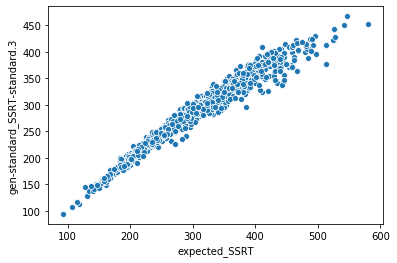

In [25]:
_ = sns.scatterplot(x='expected_SSRT', y='gen-standard_SSRT-standard.3', data=monster_df)

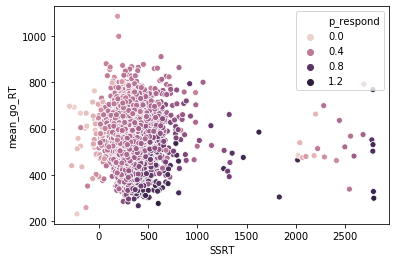

In [15]:
_ = sns.scatterplot(x='SSRT', y='mean_go_RT', hue='p_respond', data=monster_df)

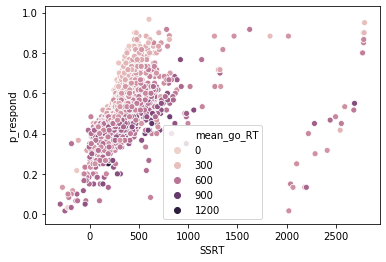

In [16]:
_ = sns.scatterplot(x='SSRT', y='p_respond', hue='mean_go_RT', data=monster_df)

In [ ]:
monster_df.query('SSRT < 0')

In [ ]:
monster_df.query('SSRT > 1000').filter(regex='SSRT')

In [ ]:
monster_df.query('SSRT > 1000')

In [ ]:
abcd_proc.query("ID == '00LJVZK2' and goRT >= 0").describe()

In [ ]:
abcd_proc.query("ID == '00LJVZK2'").describe()

In [ ]:
rt_std = abcd_proc.groupby('ID').apply(lambda x: x.describe().loc[['mean', 'std'], 'goRT'])
rt_std

In [ ]:
monster_df = pd.concat([rt_std, monster_df], 1, sort=True)
monster_df.head()

In [ ]:
fig = plt.figure(figsize=(10,5))
_ = sns.scatterplot(x='SSRT', y='p_respond', hue='std', data=monster_df)

In [ ]:
fig = plt.figure(figsize=(10,5))
_ = sns.scatterplot(x='SSRT', y='mean_go_RT', hue='std', data=monster_df)

In [ ]:
fig = plt.figure(figsize=(10,5))
_ = sns.scatterplot(x='SSRT', y='mean_SSD', hue='std', data=monster_df)

In [ ]:
fig = plt.figure(figsize=(10,5))
_ = sns.scatterplot(x='SSRT', y='mean_SSD', hue='gen-standard_SSRT-standard.2', data=monster_df)

In [ ]:
fig = plt.figure(figsize=(12,6))
_ = sns.scatterplot(x='SSRT', y='mean_SSD', size='p_respond', hue='std', data=monster_df)

In [ ]:
monster_df.query('SSRT > 1000')

In [26]:
sim_rt_info = pd.read_csv('sim_rt_meanStd.csv', index_col = 0)

FileNotFoundError: [Errno 2] File b'sim_rt_meanStd.csv' does not exist: b'sim_rt_meanStd.csv'

In [ ]:
sim_rt_info

In [ ]:
monster_df = pd.concat([sim_rt_info, monster_df], 1, sort=True)

In [ ]:
monster_df

In [ ]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='mean', y='sim_rt_mean', hue='std', data=monster_df)
_ = add_identity(ax, color='k', ls='--')

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='std', y='sim_rt_std', hue='mean', data=monster_df)
_ = add_identity(ax, color='k', ls='--')

In [ ]:
fig = plt.figure(figsize=(12,6))
ax = sns.scatterplot(x='std', y='sim_rt_std', hue='sim_rt_mean', data=monster_df)
_ = add_identity(ax, color='k', ls='--')

In [ ]:
monster_df[['sim_rt_mean', 'mean', 'sim_rt_std','std']].describe()

In [ ]:
vars_of_interest = ['mean', 'std', 'count']
ssrt_binned_dict = {}
for lower_bound in range(0,500,100):
    ssrt_binned_dict[lower_bound] = monster_df.query("mean_SSD>=%d and mean_SSD<%d" % (lower_bound, lower_bound+100))['SSRT'].describe().loc[vars_of_interest]
    
ssrt_binned_dict[500] = monster_df.query("mean_SSD>=500")['SSRT'].describe().loc[vars_of_interest]


binned_ssrt_info = pd.DataFrame(ssrt_binned_dict)
_ = sns.barplot(data=binned_ssrt_info.T.reset_index(), x='index', y='mean')
binned_ssrt_info

# looking at our mturk sample

In [ ]:
turk_var_dict = {
   "columns": {
      "ID": "Subject", #subject identifier
      "condition": "TrialType", #col with trial types 
      "correct_response": "GoTrialCorrectResponse", #col with correct reponse codes
      "response": "Response", #col with actual response codes 
      "SSD": "StopSignalDelay", #col with stop signal delay 
      "block": "Block", #col with which block a trial is accuring during
      "goRT": "GoRT", # col with go reaction time recording 
      "stopRT": "StopFailureRT", #col with stop failure reaction time recording
      "choice_accuracy": "choice_accuracy" #col with whether a response was correct
   },
   "key_codes": {
      "go": "go", # cell values for go trials  
      "stop": "stop",  #cell values for stop trials 
      "correct": 1.0,
       "incorrect": 0.0,
       "noResponse": -1
   }
}

In [ ]:
turk_path = '/Users/henrymj/Documents/ContextDependence/CleanTurkData/'

In [ ]:
turk_data = pd.read_csv(turk_path+'DataTurkSimpleLow.csv')
turk_data['Response'] = turk_data['GoTrialCorrectResponse'].combine_first(turk_data['StopTrialResponse'])

turk_stopper = StopData(var_dict=turk_var_dict, compute_acc_col=True)
turk_proc = turk_stopper.fit_transform(turk_data) 
ssrt_model = SSRTmodel(model='replacement')
turk_ssrt_metrics = ssrt_model.fit_transform(turk_proc, level='group')


vars_of_interest = ['mean', 'std', 'count']
turk_ssrt_binned_dict = {}
for lower_bound in range(0,500,100):
    turk_ssrt_binned_dict[lower_bound] = turk_ssrt_metrics.query("mean_SSD>=%d and mean_SSD<%d" % (lower_bound, lower_bound+100))['SSRT'].describe().loc[vars_of_interest]
    
turk_ssrt_binned_dict[500] = turk_ssrt_metrics.query("mean_SSD>=500")['SSRT'].describe().loc[vars_of_interest]

binned_turk_info = pd.DataFrame(turk_ssrt_binned_dict)
_ = sns.barplot(data=binned_turk_info.T.reset_index(), x='index', y='mean')
binned_turk_info

In [ ]:
turk_ssrt_metrics[['SSRT', 'mean_SSD', 'mean_go_RT']].dropna().corr()


In [ ]:
turk_data = pd.read_csv(turk_path+'DataTurkSimpleHigh.csv')
turk_data['Response'] = turk_data['GoTrialCorrectResponse'].combine_first(turk_data['StopTrialResponse'])

turk_stopper = StopData(var_dict=turk_var_dict, compute_acc_col=True)
turk_proc = turk_stopper.fit_transform(turk_data) 
ssrt_model = SSRTmodel(model='replacement')
turk_ssrt_metrics = ssrt_model.fit_transform(turk_proc, level='group')
turk_ssrt_metrics =  turk_proc.groupby('ID').apply(lambda x: ssrt_model._fit_individual(x).transform()).apply(pd.Series)


vars_of_interest = ['mean', 'std', 'count']
turk_ssrt_binned_dict = {}
for lower_bound in range(0,500,100):
    turk_ssrt_binned_dict[lower_bound] = turk_ssrt_metrics.query("mean_SSD>=%d and mean_SSD<%d" % (lower_bound, lower_bound+100))['SSRT'].describe().loc[vars_of_interest]
    
turk_ssrt_binned_dict[500] = turk_ssrt_metrics.query("mean_SSD>=500")['SSRT'].describe().loc[vars_of_interest]

binned_turk_info = pd.DataFrame(turk_ssrt_binned_dict)
_ = sns.barplot(data=binned_turk_info.T.reset_index(), x='index', y='mean')
binned_turk_info

In [ ]:
turk_ssrt_metrics[['SSRT', 'mean_SSD', 'mean_go_RT']].dropna().corr()


# Quick lil mediation analysis

In [ ]:
monster_df

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation
import statsmodels.genmod.families.links as links
probit = links.probit

data = monster_df[['SSRT', 'mean_SSD', 'mean_go_RT']].dropna().copy()
outcome_model = sm.GLM.from_formula("SSRT ~ mean_SSD + mean_go_RT",
                                     data, family=sm.families.Binomial(link=probit()))
mediator_model = sm.OLS.from_formula("mean_SSD ~ mean_go_RT", data)
med = Mediation(outcome_model, mediator_model, "mean_go_RT", mediator="mean_SSD").fit()
med.summary()

In [ ]:
outcome_model = sm.GLM.from_formula("SSRT ~ mean_SSD + mean_go_RT",
                                     data, family=sm.families.Binomial())
mediator_model = sm.OLS.from_formula("mean_SSD ~ mean_go_RT", data)
med = Mediation(outcome_model, mediator_model, "mean_go_RT", mediator="mean_SSD").fit()
med.summary()

In [ ]:
outcome_model = sm.GLM.from_formula("SSRT ~  mean_go_RT + mean_SSD",
                                     data, family=sm.families.Binomial(link=probit()))
mediator_model = sm.OLS.from_formula("mean_go_RT ~ mean_SSD", data)
med = Mediation(outcome_model, mediator_model, "mean_SSD", mediator="mean_go_RT").fit()
med.summary()

In [ ]:
data.corr()